# Modeling Adelinia Grande Bloom Status
<br>**A model is developed to predict when plants will be in bloom and when they will senesce. Model uses climate <br>data from NOAA and Skyfield and wildflower observations from iNaturalist**
<br>
<br>**Feature Selection** using pycaret
<br>**Model Training** uses observations from seven East Bay parks over five water years (2017 - 2021)
<br>**Hyperparameter Tuning** 
<br>**Model Selection** 
<br>**Model Testing** uses data from one previously unseen park (Mt. Diablo) in the East Bay

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier, VotingClassifier)
from sklearn import preprocessing
from sklearn.metrics import (f1_score, accuracy_score,confusion_matrix,
                            plot_confusion_matrix, ConfusionMatrixDisplay)
from sklearn.feature_selection import RFE

import pycaret
from pycaret.classification import (setup, compare_models, tune_model)



# Import climate and wildflower observation

<br>Observations of seven species of wildflowers were labeled as :
<br>0 = pre bloom
<br>1 = in bloom
<br>2 = in bud
<br>3 = fruiting
<br>5 = long dead and dried
<br>
<br>Modeling was done on Adelinia grande, Pacific Hound's Tongue

In [7]:
#import data file from github
#import requests
#from io import StringIO

#url = ('https://github.com/Floydworks/Capstone2_Wildflower_Phenology/blob/2132e87f3c1173975676db7fdbf842b5e446b76c/data_files/bloom_status_hyperlink.xlsx')
#export = requests.get(url).content

#df_status = pd.read_excel(StringIO(export.decode('utf-8')))

In [10]:

#import wildflower data with manually added status column for seven species
#bloom_status_hyperlink file is based on df_spring_check output in Capstone2_EDA_Wildflower_phenology notebook
df_status = pd.read_excel('/Users/sandidge/Desktop/Python_Projects/Springboard_coursework/Capstone2_Wildflowers/Capstone2_EDA/bloom_status_hyperlink.xlsx')

#list of flower species that have pre-bloom, in-bloom, and senesced observations
status_complete = ['Calochortus albus', 'Adelinia grande', 'Dipsacus sativus', 'Heracleum maximum', 
                   'Achillea millefolium', 'Bellardia trixago', 'Silybum marianum']

df_status = df_status[df_status['genus_species'].isin(status_complete)]

print('df_status shape: ',df_status.shape)
df_status.head()




df_status shape:  (1116, 39)


,Unnamed: 0,id,park,date,plain_dates,Year,Month,Day,WY,wy_month,...,MaxTemp_prior14,MinTemp_prior14,AvgMaxTemp_prior14,AvgMinTemp_prior14,MaxDayLen_prior14,MaxTemp_prior30,MinTemp_prior30,AvgMaxTemp_prior30,AvgMinTemp_prior30,MaxDayLen_prior30
0,15848,67913787,JDGrant,2021-01-06,20210106,2021,1,6,2021,4,...,56.5,35.5,53.250000,39.285714,34932,69.0,35.0,55.316667,40.000000,34932
1,1928,104737736,Sunol,2022-01-10,20220110,2022,1,10,2022,4,...,63.5,29.0,56.535714,40.750000,35108,63.5,29.0,55.383333,40.483333,35108
2,16026,37506377,Garin,2020-01-11,20200111,2020,1,11,2020,4,...,63.0,37.0,58.642857,41.214286,35102,63.0,36.0,58.166667,42.533333,35102
3,15236,104948979,JDGrant,2022-01-14,20220114,2022,1,14,2022,4,...,64.5,31.0,56.535714,41.857143,35448,64.5,31.0,52.300000,39.250000,35448
4,15239,105516029,JDGrant,2022-01-24,20220124,2022,1,24,2022,4,...,65.0,40.0,60.571429,43.928571,36352,65.0,31.0,55.200000,40.966667,36352


In [11]:
#drop observations with status = 5
df = df_status[df_status.status != 5]
#change in-bud = 2 to pre-bloom = 0
df['status'] = np.where(df['status'] == 2, 0, df['status'])

print(df['status'].unique())

[0. 1. 3.]


In [12]:
#check for any parks that had no observations of target species
df['park'].unique()

array(['JDGrant', 'Sunol', 'Garin', 'Briones', 'Tilden', 'AChabot',
       'PRidge'], dtype=object)

# Look at counts by status and species

In [13]:
#get number of obesrvations in each status class for each species and convert to a dataframe
df_counts = df.groupby(['genus_species', 'status'])['id'].count().to_frame()
#create total_obs column fill with nan placeholders
df_counts['total_obs'] = 'nan'
#reset the index and move genus_species to a column
df_counts=df_counts.reset_index()
#get list of species to iterate through
spp = df_counts['genus_species'].unique()
#go through species and add total observations of that species to the total_obs column
for sp in spp:
    sum_obs = df_counts.loc[df_counts['genus_species'] == sp, 'id'].sum()
    df_counts['total_obs'] = np.where(df_counts['genus_species'] == sp, sum_obs, df_counts['total_obs'])
 #calculate the percentage of observations for each status class  and species  
df_counts['percent_obs'] = df_counts['id']/df_counts['total_obs']

#see counts of all species with labeled bloom status
#df_counts

#just Adelinia grande
df_counts[df_counts['genus_species']=='Adelinia grande']

,genus_species,status,id,total_obs,percent_obs
2,Adelinia grande,0.0,14,191,0.073298
3,Adelinia grande,1.0,158,191,0.827225
4,Adelinia grande,3.0,19,191,0.099476


In [14]:
#select species of interest
df_ag = df[df['genus_species']=='Adelinia grande']

#df_ds = df[df['genus_species']=='Dipsacus sativus']

#df_sm = df[df['genus_species']=='Silybum marianum']


In [15]:
#reorder features
data_modeling = df_ag[['prec_daily','prec_cum_WY', 'MonSumPrec', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

print(data_modeling.shape)
data_modeling.head()

(191, 20)


,prec_daily,prec_cum_WY,MonSumPrec,WkSumPrec,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
170,0.0,15.270,0.250,0.00,0.860,8.990,40.0,32.0,42.285714,32.0,54.166667,61.0,61.0,54.071429,61.0,42.600000,34920,34920,34920,0.0
171,0.0,13.075,0.105,0.00,0.105,4.155,48.5,38.5,43.928571,31.0,53.116667,61.0,65.0,58.357143,65.0,39.950000,35609,35609,35609,0.0
172,0.0,5.680,3.200,0.14,0.140,2.990,40.0,36.0,45.285714,35.0,60.466667,61.0,66.0,59.285714,66.0,44.100000,36090,36090,36090,0.0
173,0.0,13.075,0.105,0.00,0.000,2.240,40.0,40.0,43.928571,31.0,55.200000,60.0,65.0,60.571429,65.0,40.966667,36352,36352,36352,1.0
174,0.0,5.515,2.665,0.12,1.465,2.545,42.5,37.0,44.535714,32.5,60.150000,65.5,67.5,62.000000,67.5,42.600000,36570,36570,36570,0.0


# Climate variable features: Adelinia grande, Pacific Hound's Tongue
<br> look at correlations and distributions of all climate variables

___________

<AxesSubplot:title={'center':'Correlation plot all climate features'}>

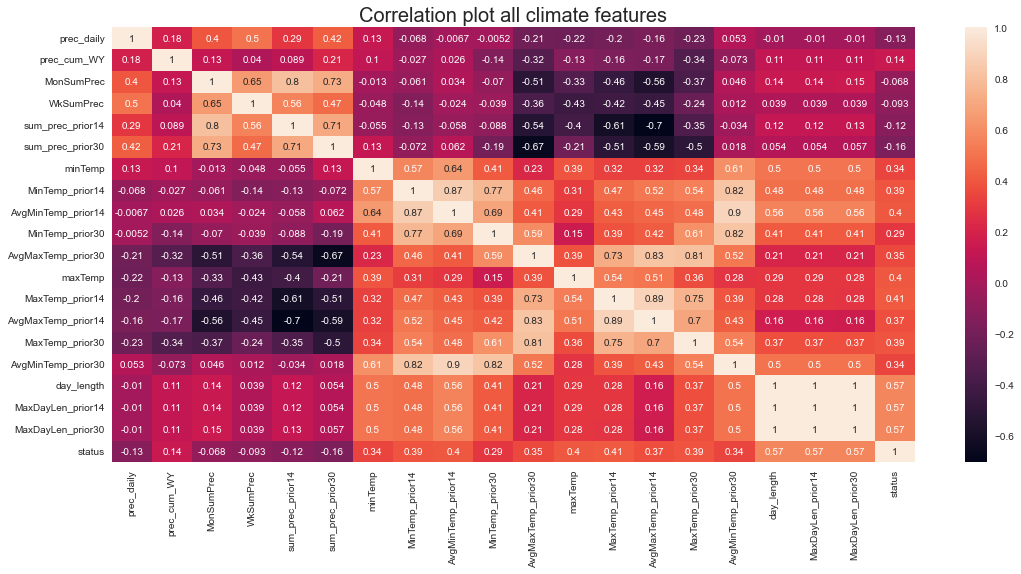

In [16]:
#Plot the correlation heat map for all features

plt.subplots(figsize=(18,8))
plt.title('Correlation plot all climate features', fontsize = 20)
sns.heatmap(data_modeling.corr(), annot=True)

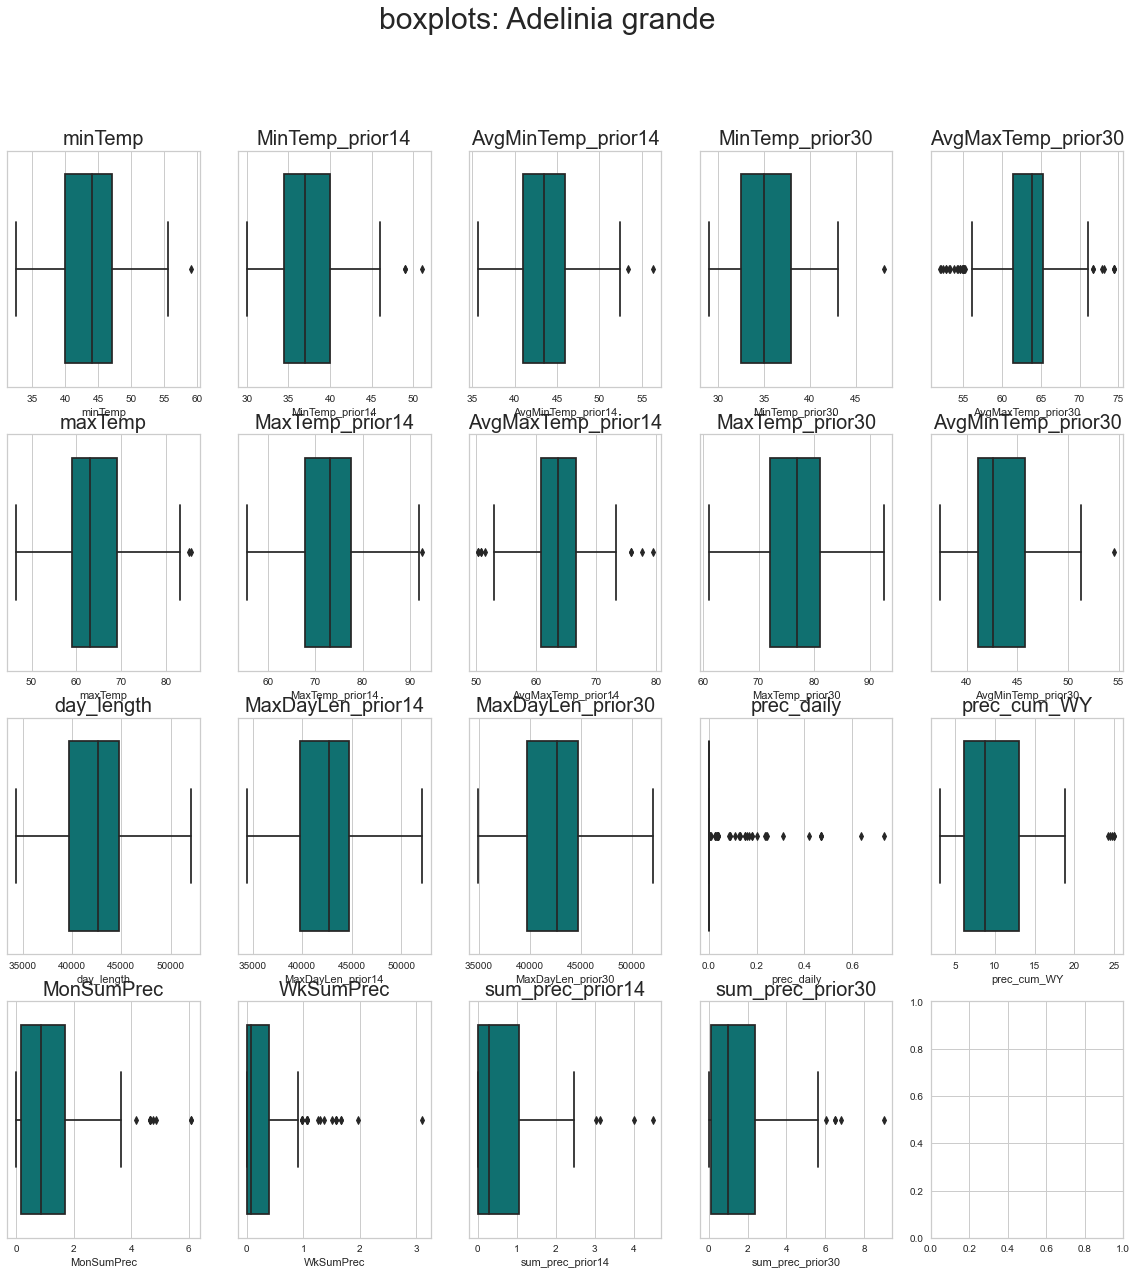

In [17]:
#Boxplots of climate variables
columns = ['minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30', 
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30',
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30','prec_daily','prec_cum_WY', 
           'MonSumPrec', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30'
          ]

ax0 = [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
ax1 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]

tups = list(zip(ax1 ,ax0))

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
fig.suptitle('boxplots: Adelinia grande', fontsize=30)

for col, ax in zip(columns, tups):
    sns.boxplot(x=data_modeling[col], ax=axes[ax], color = 'teal'), 
    axes[ax].set_title(str(col), fontsize=20)

# Model and Feature Selection with Pycaret

# Feature Selection
<br> Code Source: 
<br>https://github.com/arnaldo9408/IpZDfXDexbdIJIWY/blob/main/Team%20Deposit%20Marketing.ipynb
_________
<br>Methods:
<br> model was trained on data from 7 parks over 5 years
<br> 80 percent of the data was used to train the model, 20 percent to test it
___________


In [18]:
#look at data_modeling
print(data_modeling.shape)
data_modeling.head()

(191, 20)


,prec_daily,prec_cum_WY,MonSumPrec,WkSumPrec,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
170,0.0,15.270,0.250,0.00,0.860,8.990,40.0,32.0,42.285714,32.0,54.166667,61.0,61.0,54.071429,61.0,42.600000,34920,34920,34920,0.0
171,0.0,13.075,0.105,0.00,0.105,4.155,48.5,38.5,43.928571,31.0,53.116667,61.0,65.0,58.357143,65.0,39.950000,35609,35609,35609,0.0
172,0.0,5.680,3.200,0.14,0.140,2.990,40.0,36.0,45.285714,35.0,60.466667,61.0,66.0,59.285714,66.0,44.100000,36090,36090,36090,0.0
173,0.0,13.075,0.105,0.00,0.000,2.240,40.0,40.0,43.928571,31.0,55.200000,60.0,65.0,60.571429,65.0,40.966667,36352,36352,36352,1.0
174,0.0,5.515,2.665,0.12,1.465,2.545,42.5,37.0,44.535714,32.5,60.150000,65.5,67.5,62.000000,67.5,42.600000,36570,36570,36570,0.0


In [19]:
data_modeling = df_ag[['prec_daily','prec_cum_WY', 'MonSumPrec', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

print(data_modeling.shape)
data_modeling.head()

(191, 20)


,prec_daily,prec_cum_WY,MonSumPrec,WkSumPrec,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
170,0.0,15.270,0.250,0.00,0.860,8.990,40.0,32.0,42.285714,32.0,54.166667,61.0,61.0,54.071429,61.0,42.600000,34920,34920,34920,0.0
171,0.0,13.075,0.105,0.00,0.105,4.155,48.5,38.5,43.928571,31.0,53.116667,61.0,65.0,58.357143,65.0,39.950000,35609,35609,35609,0.0
172,0.0,5.680,3.200,0.14,0.140,2.990,40.0,36.0,45.285714,35.0,60.466667,61.0,66.0,59.285714,66.0,44.100000,36090,36090,36090,0.0
173,0.0,13.075,0.105,0.00,0.000,2.240,40.0,40.0,43.928571,31.0,55.200000,60.0,65.0,60.571429,65.0,40.966667,36352,36352,36352,1.0
174,0.0,5.515,2.665,0.12,1.465,2.545,42.5,37.0,44.535714,32.5,60.150000,65.5,67.5,62.000000,67.5,42.600000,36570,36570,36570,0.0


In [20]:
# Get the dependent and independent feature(s)
X = data_modeling.drop('status', axis = 1).values
y = data_modeling['status'].values

# Divide into train (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)

In [28]:
# Start the feature selection

# Define RFE (recursive feature elimination)
rfe_dt = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=17)
rfe_rf = RFE(estimator=RandomForestClassifier(), n_features_to_select=17)
rfe_gb = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=17)

# fit RFE
rfe_dt.fit(X_train, y_train)
rfe_rf.fit(X_train, y_train)
rfe_gb.fit(X_train, y_train)

# Create a list with the features, status as index, then remove index
features = list(data_modeling.columns)
index = features.index('status')
features.pop(index)

# Create an empty list to see if the feature was selected
is_selected_dt = []
is_selected_rf = []
is_selected_gb = []

# Create an empty list with the rank
ranks_dt = []
ranks_rf = []
ranks_gb = []

# Summarize all features
for i in range(X.shape[1]):
    is_selected_value = rfe_dt.support_[i]
    is_selected_dt.append(is_selected_value)
    rank = rfe_dt.ranking_[i]
    ranks_dt.append(rank)
    
for i in range(X.shape[1]):
    is_selected_value = rfe_rf.support_[i]
    is_selected_rf.append(is_selected_value)
    rank = rfe_rf.ranking_[i]
    ranks_rf.append(rank)    
    
for i in range(X.shape[1]):
    is_selected_value = rfe_gb.support_[i]
    is_selected_gb.append(is_selected_value)
    rank = rfe_gb.ranking_[i]
    ranks_gb.append(rank)    

In [29]:
# Define a function that will sort the ranks of each feature and if the feature was selected
def df_converter(is_selected, ranks):
    feature_selection = pd.DataFrame()
    feature_selection['Feature'] = features
    feature_selection['is_selected'] = is_selected
    feature_selection['ranks'] = ranks
    sorted_ranks = feature_selection.sort_values(by = 'ranks', ascending = True).reset_index(drop = True)
    return sorted_ranks

In [30]:
# Function that converts the arrays created to data frame
def converter_df(train_independent, train_dependent):
    df = pd.DataFrame(train_independent)
    df['dependent'] = train_dependent
    return df

In [31]:
# Create the data frame for the train data
df = converter_df(train_independent = X_train, train_dependent = y_train)

# run Pycaret feature/model selection

In [32]:
# Setup the dataset
grid = setup(data = df, target = df.columns[-1]) #dependent variable is last column

# Evaluate models and compare models
best = compare_models()

# Report the best model
print(best)

,Description,Value
0,Session id,2274
1,Target,dependent
2,Target type,Multiclass
3,Target mapping,"0.0: 0, 1.0: 1, 3.0: 2"
4,Original data shape,"(152, 20)"
5,Transformed data shape,"(152, 20)"
6,Transformed train set shape,"(106, 20)"
7,Transformed test set shape,"(46, 20)"
8,Numeric features,19
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8873,0.5320,0.8873,0.8248,0.8533,0.3940,0.3997,0.0390
et,Extra Trees Classifier,0.8873,0.5450,0.8873,0.8233,0.8529,0.4206,0.4376,0.0340
ridge,Ridge Classifier,0.8782,0.0000,0.8782,0.7731,0.8218,0.2530,0.2755,0.1610
lda,Linear Discriminant Analysis,0.8764,0.5627,0.8764,0.8134,0.8425,0.3734,0.3961,0.0080
ada,Ada Boost Classifier,0.8691,0.4856,0.8691,0.8049,0.8341,0.3760,0.3992,0.0180
xgboost,Extreme Gradient Boosting,0.8682,0.4987,0.8682,0.8050,0.8342,0.3787,0.4009,0.0170
gbc,Gradient Boosting Classifier,0.8673,0.5017,0.8673,0.8196,0.8415,0.3308,0.3363,0.0410
catboost,CatBoost Classifier,0.8582,0.5751,0.8582,0.7987,0.8250,0.2914,0.3107,0.4610
knn,K Neighbors Classifier,0.8500,0.5128,0.8500,0.7598,0.7985,0.2082,0.2213,0.1330
lr,Logistic Regression,0.8409,0.3442,0.8409,0.7087,0.7687,0.0000,0.0000,0.5370


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=2274, verbose=0, warm_start=False)


**model selection summary:**
<br>19 features selected, all in, 
<br>ac = 88-89%, sometimes above 90, 
<br>best models: catboost, extra trees, random forest, knn, gradient boosting
<br>
<br>**BEST MODEL**
<br>17 features selected,  Drop: *prec_daily, *mon_sum_prec
<br>ac = 88-91% sometimes up to 95%, 
<br>best models: random forest, knn, extra trees, catboost, extreme gradient 
<br>
<br>15 features selected, Drop: prec_daily, mon_sum_prec, min_temp_prior30, MaxDayLen_prior14 
<br>ac = 88-89% up to 92%
<br>best models: knn, random forest, gradient boosting, extra trees, catboost
<br>
<br>10 features selected, Drop: prec_daily, mon_sum_prec, min_temp_prior30, sum_prec_prior14, 
<br>wk_sum_prec, min_temp, day_length, MaxDayLen_prior14, AvgMaxTemp_prior14
<br>ac = 88-90%
<br>best models: knn, random forest, extra trees, catboost, extreme gradient boosting
<br>
<br>8 features selected, max temp and daylength are most important, ac = 88-89, occasional 92
<br>random forest, knn, ridge, extra trees

In [34]:
# Feature Selection for Random Forest Classifier

df_converter(is_selected = is_selected_rf, ranks = ranks_rf)

,Feature,is_selected,ranks
0,MinTemp_prior30,True,1
1,day_length,True,1
2,AvgMinTemp_prior30,True,1
3,MaxTemp_prior30,True,1
4,AvgMaxTemp_prior14,True,1
5,MaxTemp_prior14,True,1
6,maxTemp,True,1
7,AvgMaxTemp_prior30,True,1
8,MaxDayLen_prior14,True,1
9,MaxDayLen_prior30,True,1


In [35]:
# Feature Selection for Gradient Boosting Classifier

df_converter(is_selected = is_selected_gb, ranks = ranks_gb)

,Feature,is_selected,ranks
0,MaxDayLen_prior30,True,1
1,MaxTemp_prior30,True,1
2,AvgMaxTemp_prior14,True,1
3,MaxTemp_prior14,True,1
4,maxTemp,True,1
5,AvgMaxTemp_prior30,True,1
6,MaxDayLen_prior14,True,1
7,AvgMinTemp_prior30,True,1
8,AvgMinTemp_prior14,True,1
9,minTemp,True,1


In [36]:
# Feature Selection for Decision Trees Classifier

df_converter(is_selected = is_selected_dt, ranks = ranks_dt)

,Feature,is_selected,ranks
0,MaxDayLen_prior30,True,1
1,MaxTemp_prior30,True,1
2,AvgMaxTemp_prior14,True,1
3,MaxTemp_prior14,True,1
4,maxTemp,True,1
5,AvgMaxTemp_prior30,True,1
6,MaxDayLen_prior14,True,1
7,AvgMinTemp_prior30,True,1
8,AvgMinTemp_prior14,True,1
9,minTemp,True,1


In [37]:
#model with all features
#data_modeling = df_ag[['prec_daily','prec_cum_WY', 'MonSumPrec', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
#           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
#           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
#           'status']]
        
#model for 17 features, Drop: 'prec_daily', 'MonSumPrec'
data_modeling = df_ag[['prec_cum_WY', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

#model for 15 features, Drop: 'prec_daily', 'MonSumPrec', 'MinTemp_prior30', 'MaxDayLen_prior14'
#data_modeling = df_ag[['prec_cum_WY', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
#           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14', 'AvgMaxTemp_prior30',
#           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'day_length', 'MaxDayLen_prior30',
#           'status']]

#model for 10 features, Drop: prec_daily, mon_sum_prec, min_temp_prior30, sum_prec_prior14, 
#wk_sum_prec, min_temp, day_length, MaxDayLen_prior14, AvgMaxTemp_prior14
#data_modeling = df_ag[['prec_cum_WY', 'sum_prec_prior30', 
#           'MinTemp_prior14', 'AvgMinTemp_prior14', 'AvgMaxTemp_prior30',
#           'maxTemp', 'MaxTemp_prior14', 'MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'MaxDayLen_prior30',
#           'status']]

#30 day prior
#data_modeling = df_ag[['prec_cum_WY', 'WkSumPrec','sum_prec_prior30', 
#           'MinTemp_prior30', 'AvgMaxTemp_prior30',
#           'MaxTemp_prior30', 'AvgMinTemp_prior30', 
#           'MaxDayLen_prior30',
#           'status']]

print(data_modeling.shape)
data_modeling.head()

(191, 18)


,prec_cum_WY,WkSumPrec,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
170,15.270,0.00,0.860,8.990,40.0,32.0,42.285714,32.0,54.166667,61.0,61.0,54.071429,61.0,42.600000,34920,34920,34920,0.0
171,13.075,0.00,0.105,4.155,48.5,38.5,43.928571,31.0,53.116667,61.0,65.0,58.357143,65.0,39.950000,35609,35609,35609,0.0
172,5.680,0.14,0.140,2.990,40.0,36.0,45.285714,35.0,60.466667,61.0,66.0,59.285714,66.0,44.100000,36090,36090,36090,0.0
173,13.075,0.00,0.000,2.240,40.0,40.0,43.928571,31.0,55.200000,60.0,65.0,60.571429,65.0,40.966667,36352,36352,36352,1.0
174,5.515,0.12,1.465,2.545,42.5,37.0,44.535714,32.5,60.150000,65.5,67.5,62.000000,67.5,42.600000,36570,36570,36570,0.0


# Modeling training data with various classifiers

In [38]:
model_train_list = []
ac_train_list = []
precision_train_list = []
recall_train_list = []

# Train the model: Adelinia grande, Pacific Hound's Tongue

 

In [39]:
#Create dummy features for object type features.
X = data_modeling.drop('status', axis=1)
X = pd.get_dummies(X)
y = data_modeling['status']

# Random Forest

In [40]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#implement the random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('Random Forest')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)


Random Forest: Accuracy=0.846
Random Forest: f1-score=0.802
Precision = nan
Recall = 1.500


Adelinia grande: blooming confusion matrix 
[[ 0  3  0]
 [ 0 30  0]
 [ 0  3  3]]


17


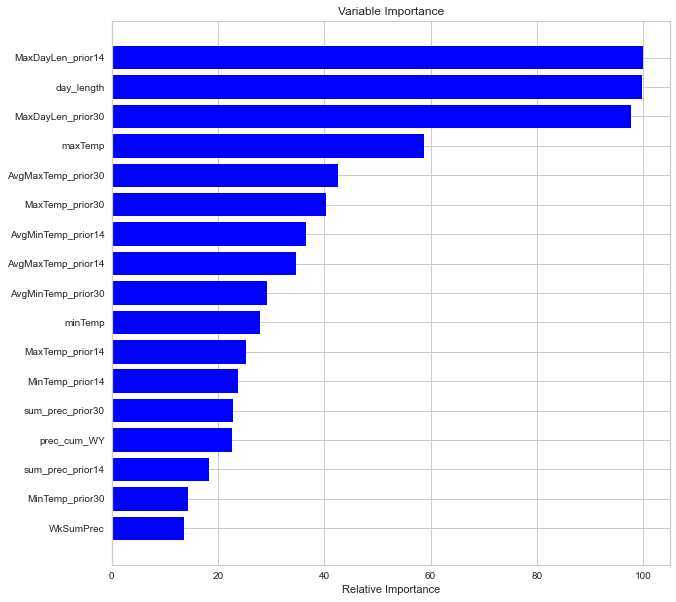

In [41]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# K Nearest Neighbor

In [42]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
model_res = knn.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('KNN')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('KNN: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)


KNN: Accuracy=0.821
Precision = nan
Recall = 1.333

Adelinia grande: blooming confusion matrix 
[[ 0  3  0]
 [ 0 30  0]
 [ 0  4  2]]


# Extra Trees

In [44]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Create Extra Trees Classifier
ext = ExtraTreesClassifier(n_estimators=100)

#Train the model using the training sets
model_res = ext.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('Extra Trees')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('ext: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

ext: Accuracy=0.795
Precision = 1.806
Recall = 1.300

Adelinia grande: blooming confusion matrix 
[[ 0  3  0]
 [ 1 29  0]
 [ 0  4  2]]


17


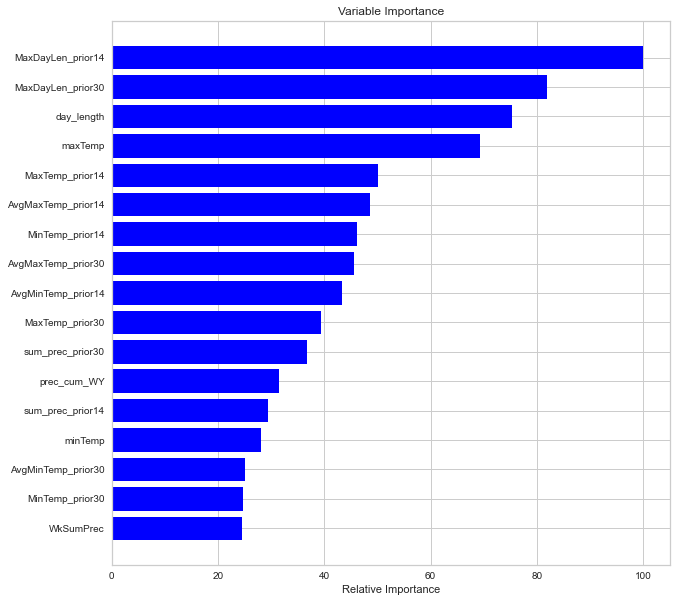

In [45]:
feature_importance = ext.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Gradient Boosting

In [66]:
#define X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

#Create Gradient Boosting Classifier
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

#Train the model using the training sets
model_res = gb.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_train_list.append('Gradient Boosting')
ac_train_list.append(ac)
precision_train_list.append(precision)
recall_train_list.append(recall)

print('gb: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

gb: Accuracy=0.846
Precision = 2.833
Recall = 1.667

Adelinia grande: blooming confusion matrix 
[[ 1  2  0]
 [ 0 30  0]
 [ 0  4  2]]


Feature: 0, Score: 11.61655
Feature: 1, Score: 36.81649
Feature: 2, Score: 11.20892
Feature: 3, Score: 19.46673
Feature: 4, Score: 1.94288
Feature: 5, Score: 14.26891
Feature: 6, Score: 4.62183
Feature: 7, Score: 0.26387
Feature: 8, Score: 13.43706
Feature: 9, Score: 74.84827
Feature: 10, Score: 4.67591
Feature: 11, Score: 24.30209
Feature: 12, Score: 8.77892
Feature: 13, Score: 16.82348
Feature: 14, Score: 72.46446
Feature: 15, Score: 100.00000
Feature: 16, Score: 97.55506
17


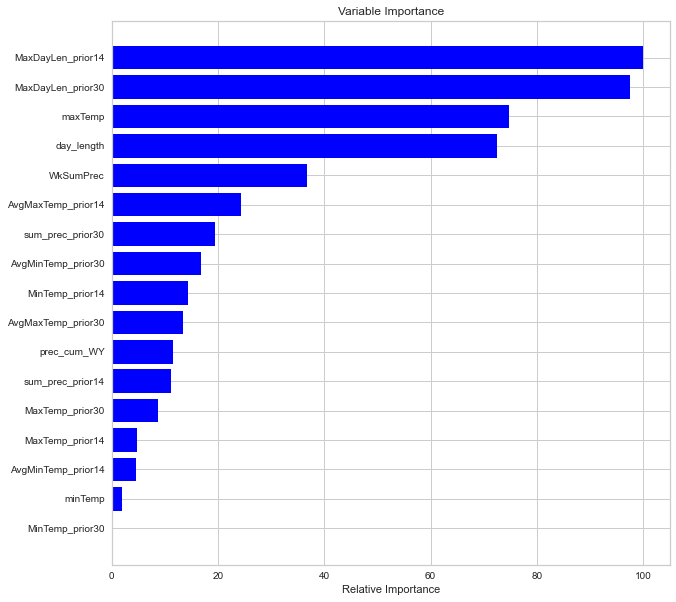

In [74]:
feature_importance = gb.feature_importances_
    
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

# summarize feature importance
for i,v in enumerate(feature_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [70]:
gb

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [48]:
models_train_table = pd.DataFrame()
models_train_table.index = model_train_list
models_train_table['accuracy'] = ac_train_list
models_train_table['precision'] = precision_train_list
models_train_table['recall'] = recall_train_list

models_train_table.head(10)

,accuracy,precision,recall
Random Forest,0.846154,NaN,1.500000
KNN,0.820513,NaN,1.333333
Extra Trees,0.794872,1.805556,1.300000
Gradient Boosting,0.846154,2.833333,1.666667


________________________
# Model New Data: Import climate and wildflower observation
<br>New data is used from one park, Mt. Diablo, over 5 years

In [49]:
#import wildflower data with manually added status column for seven species

df_testing = pd.read_csv('/Users/sandidge/Desktop/Python_Projects/Springboard_coursework/Capstone2_Wildflowers/Capstone2_EDA/mtdiablo_test.csv')

#list of flower species that have pre-bloom, in-bloom, and senesced observations
status_complete = ['Adelinia grande']
#status_complete = ['Calochortus albus', 'Adelinia grande', 'Dipsacus sativus', 'Heracleum maximum', 
#                   'Achillea millefolium', 'Bellardia trixago', 'Silybum marianum']

#select data for species with completed photo labeling
df_testing = df_testing[df_testing['genus_species'].isin(status_complete)]

#drop observations with status = 5
df = df_testing[df_testing.status != 5]
df['status'] = np.where(df['status'] == 2, 0, df['status'])

print(df['status'].unique())

print('df_testing shape: ',df_testing.shape)
df_testing.head()


[0. 1. 3.]
df_testing shape:  (216, 41)


,id,park,plain_dates,Year,Month,Day,WY,wy_month,WY_weeknum,genus_species,...,sum_prec_prior30,MaxTemp_prior30,MinTemp_prior30,AvgMaxTemp_prior30,AvgMinTemp_prior30,MaxDayLen_prior30,url,image_url,Unnamed: 39,status
301,104085492,MtDiablo,20211230,2021,12,30,2022,3,12,Adelinia grande,...,8.358268,73.94,28.94,52.100,40.088,35034,https://www.inaturalist.org/observations/10408...,https://inaturalist-open-data.s3.amazonaws.com...,https://inaturalist-open-data.s3.amazonaws.com...,0.0
302,104559483,MtDiablo,20220106,2022,1,6,2022,4,13,Adelinia grande,...,8.377953,55.94,28.94,47.378,37.118,34745,https://www.inaturalist.org/observations/10455...,https://inaturalist-open-data.s3.amazonaws.com...,https://inaturalist-open-data.s3.amazonaws.com...,0.0
303,105112877,MtDiablo,20220116,2022,1,16,2022,4,15,Adelinia grande,...,4.027559,64.94,28.94,50.942,39.782,35451,https://www.inaturalist.org/observations/10511...,https://inaturalist-open-data.s3.amazonaws.com...,https://inaturalist-open-data.s3.amazonaws.com...,0.0
304,113319812,MtDiablo,20220121,2022,1,21,2022,4,15,Adelinia grande,...,3.346457,64.94,28.94,52.610,41.648,35907,https://www.inaturalist.org/observations/11331...,https://inaturalist-open-data.s3.amazonaws.com...,https://inaturalist-open-data.s3.amazonaws.com...,1.0
305,105457143,MtDiablo,20220122,2022,1,22,2022,4,15,Adelinia grande,...,1.677165,64.94,28.94,52.772,41.648,36006,https://www.inaturalist.org/observations/10545...,https://inaturalist-open-data.s3.amazonaws.com...,https://inaturalist-open-data.s3.amazonaws.com...,0.0


In [50]:
df_testing['park'].unique()

array(['MtDiablo'], dtype=object)

# Look at counts by status and species

In [51]:
#get number of obesrvations in each status class for each species and convert to a dataframe
df_counts = df.groupby(['genus_species', 'status'])['id'].count().to_frame()
#create total_obs column fill with nan placeholders
df_counts['total_obs'] = 'nan'
#reset the index and move genus_species to a column
df_counts=df_counts.reset_index()
#get list of species to iterate through
spp = df_counts['genus_species'].unique()
#go through species and add total observations of that species to the total_obs column
for sp in spp:
    sum_obs = df_counts.loc[df_counts['genus_species'] == sp, 'id'].sum()
    df_counts['total_obs'] = np.where(df_counts['genus_species'] == sp, sum_obs, df_counts['total_obs'])
 #calculate the percentage of observations for each status class  and species  
df_counts['percent_obs'] = df_counts['id']/df_counts['total_obs']

df_counts

,genus_species,status,id,total_obs,percent_obs
0,Adelinia grande,0.0,25,216,0.115741
1,Adelinia grande,1.0,170,216,0.787037
2,Adelinia grande,3.0,21,216,0.097222


In [52]:
#select species of interest
df_ag_test = df[df['genus_species']=='Adelinia grande']

#model for 17 features, Drop: 'prec_daily', 'MonSumPrec'
df_ag_test = df_ag[['prec_cum_WY', 'WkSumPrec', 'sum_prec_prior14','sum_prec_prior30', 
           'minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30',
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30', 
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30',
           'status']]

print(df_ag_test.shape)
df_ag_test.head()

(191, 18)


,prec_cum_WY,WkSumPrec,sum_prec_prior14,sum_prec_prior30,minTemp,MinTemp_prior14,AvgMinTemp_prior14,MinTemp_prior30,AvgMaxTemp_prior30,maxTemp,MaxTemp_prior14,AvgMaxTemp_prior14,MaxTemp_prior30,AvgMinTemp_prior30,day_length,MaxDayLen_prior14,MaxDayLen_prior30,status
170,15.270,0.00,0.860,8.990,40.0,32.0,42.285714,32.0,54.166667,61.0,61.0,54.071429,61.0,42.600000,34920,34920,34920,0.0
171,13.075,0.00,0.105,4.155,48.5,38.5,43.928571,31.0,53.116667,61.0,65.0,58.357143,65.0,39.950000,35609,35609,35609,0.0
172,5.680,0.14,0.140,2.990,40.0,36.0,45.285714,35.0,60.466667,61.0,66.0,59.285714,66.0,44.100000,36090,36090,36090,0.0
173,13.075,0.00,0.000,2.240,40.0,40.0,43.928571,31.0,55.200000,60.0,65.0,60.571429,65.0,40.966667,36352,36352,36352,1.0
174,5.515,0.12,1.465,2.545,42.5,37.0,44.535714,32.5,60.150000,65.5,67.5,62.000000,67.5,42.600000,36570,36570,36570,0.0


# Climate variable features: Adelinia grande, Pacific Hound's Tongue
<br> uses min, max and averages of temp and precipitation over the previous 30 days.
_______________

<AxesSubplot:title={'center':'Correlation of climate variables'}>

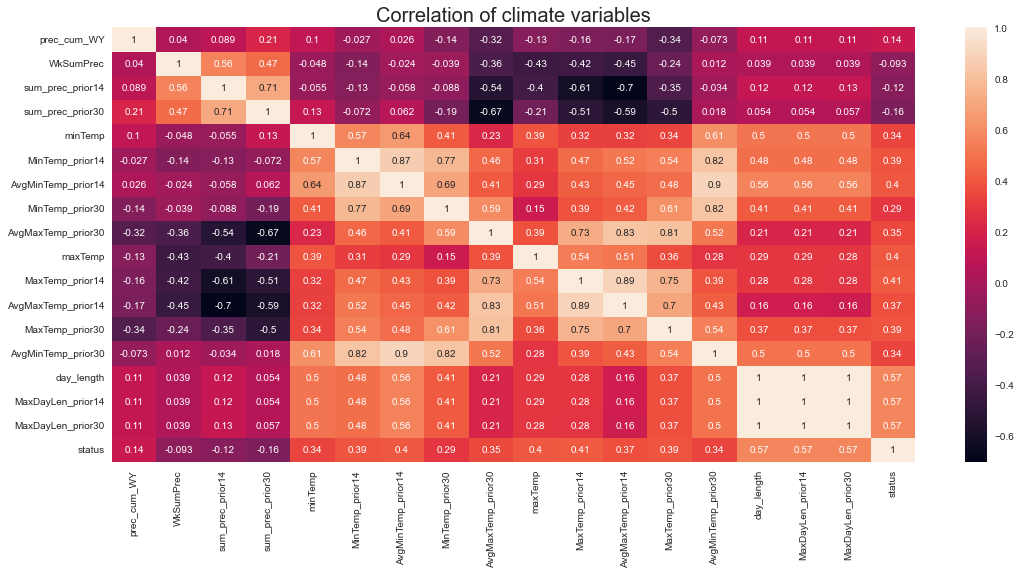

In [53]:
#Plot the correlation heat map for the features

plt.subplots(figsize=(18,8))
plt.title('Correlation of climate variables', fontsize = 20)
sns.heatmap(df_ag_test.corr(), annot=True)

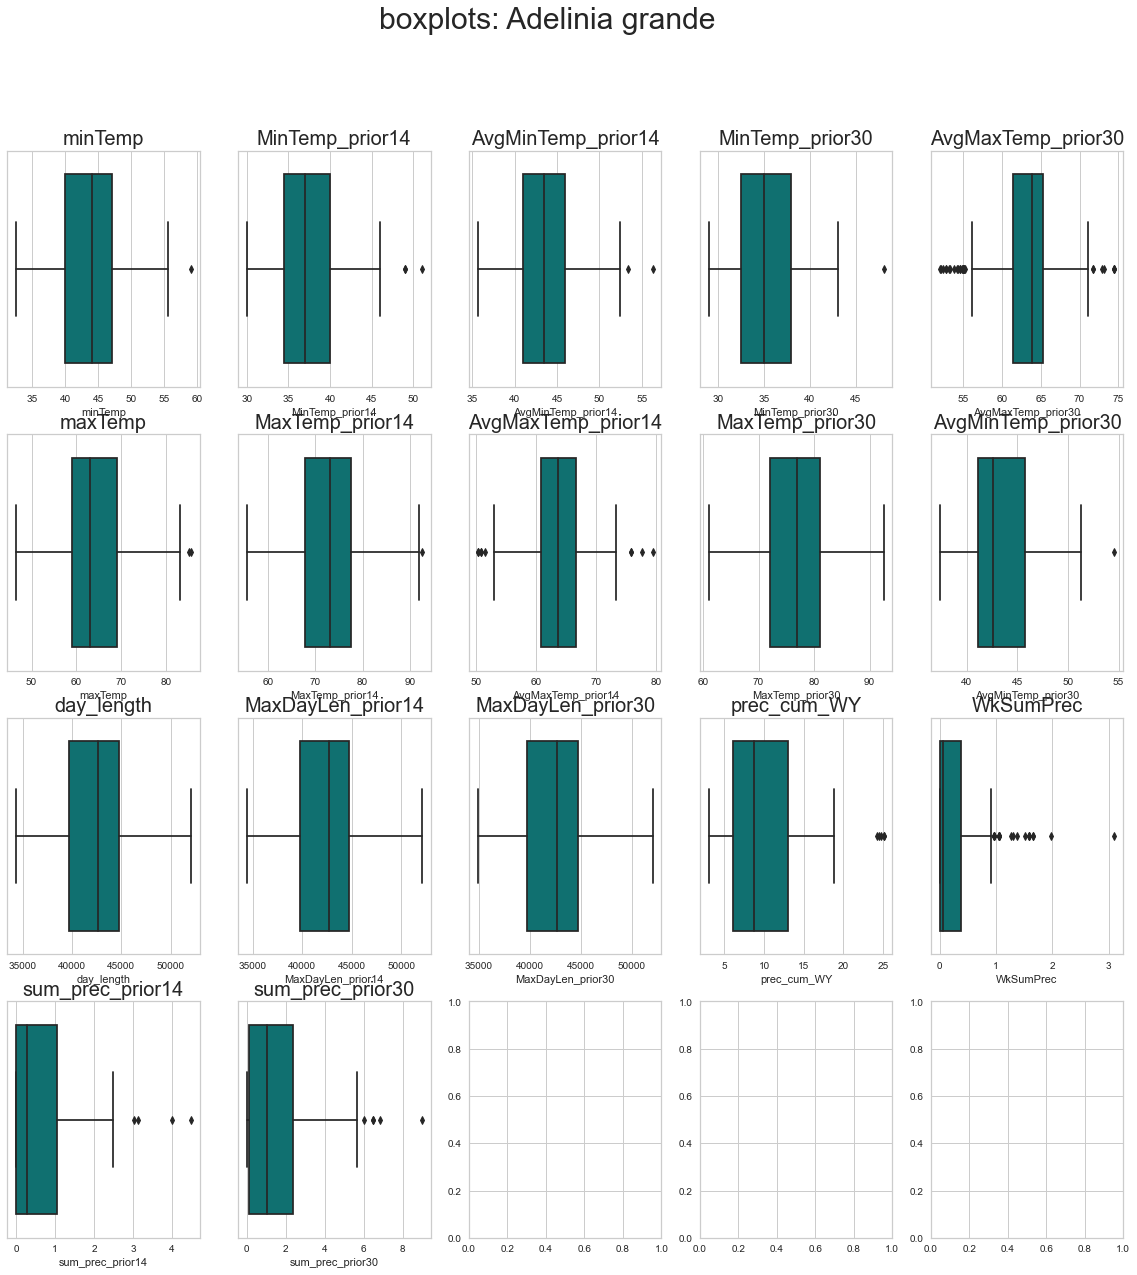

In [54]:
#Boxplots of climate variables
columns = ['minTemp', 'MinTemp_prior14', 'AvgMinTemp_prior14','MinTemp_prior30', 'AvgMaxTemp_prior30', 
           'maxTemp', 'MaxTemp_prior14', 'AvgMaxTemp_prior14','MaxTemp_prior30', 'AvgMinTemp_prior30',
           'day_length', 'MaxDayLen_prior14', 'MaxDayLen_prior30','prec_cum_WY', 'WkSumPrec', 
           'sum_prec_prior14','sum_prec_prior30'
          ]

ax0 = [0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4]
ax1 = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]

tups = list(zip(ax1 ,ax0))

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
fig.suptitle('boxplots: Adelinia grande', fontsize=30)

for col, ax in zip(columns, tups):
    sns.boxplot(x=data_modeling[col], ax=axes[ax], color = 'teal'), 
    axes[ax].set_title(str(col), fontsize=20)

# Modeling test data with various classifiers

In [55]:
model_list = []
ac_list = []
precision_list = []
recall_list = []

# Test: Random Forest

In [56]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag_test.drop('status', axis=1)
X_md = pd.get_dummies(X)
y_md = df_ag_test['status']


#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled=scaler.transform(X_train)

#TEST DATA
X_md_scaled=scaler.transform(X_md)

#implement the random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

f1 = f1_score(y_md, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('Random Forest')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

Random Forest: Accuracy=0.963
Random Forest: f1-score=0.961
Precision = 2.958
Recall = 2.556


Adelinia grande: blooming confusion matrix 
[[ 10   4   0]
 [  0 158   0]
 [  0   3  16]]


17


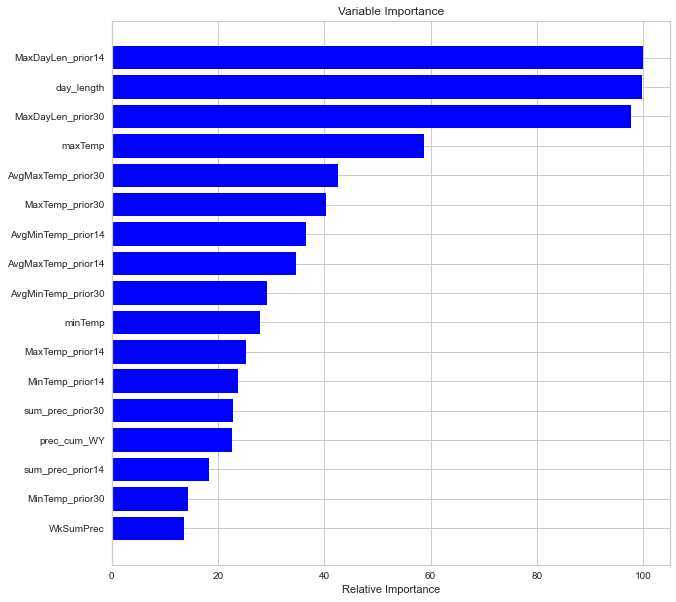

In [57]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Test: K Nearest Neighbor

In [58]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag.drop('status', axis=1)
X_md = pd.get_dummies(X)
y_md = df_ag['status']

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)

X_md_scaled=scaler.transform(X_md)

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=9)

#Train the model using the training sets
model_res = knn.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('KNN')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('KNN: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

KNN: Accuracy=0.880
Precision = 2.786
Recall = 1.591

Adelinia grande: blooming confusion matrix 
[[  1  13   0]
 [  0 157   1]
 [  0   9  10]]


In [59]:
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

print(true_pos)
print(precision)
print(recall)

[  1 157  10]
2.786185881157948
1.591415246978205


# Test: ExtraTreesClassifier

In [60]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag.drop('status', axis=1)
X_md = pd.get_dummies(X)
y_md = df_ag['status']

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)

X_md_scaled=scaler.transform(X_md)

#Create extra trees Classifier
ext = ExtraTreesClassifier(n_estimators=100)

#Train the model using the training sets
model_res = ext.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('Extra Trees')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('ext: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

ext: Accuracy=0.953
Precision = 2.803
Recall = 2.563

Adelinia grande: blooming confusion matrix 
[[ 11   3   0]
 [  2 156   0]
 [  0   4  15]]


17


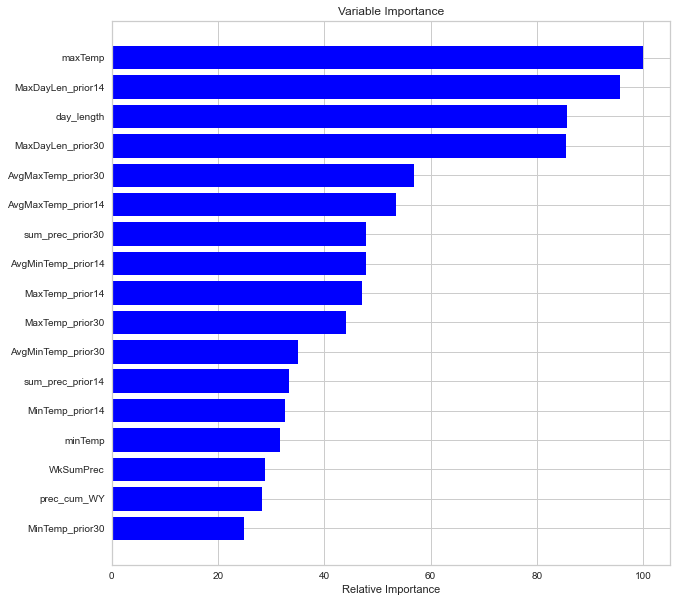

In [62]:
feature_importance = ext.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Test: GradientBoostingClassifier

In [63]:
#define X and y
#Create dummy features for object type features.
X_md = df_ag.drop('status', axis=1)
X_md = pd.get_dummies(X)
y_md = df_ag['status']

#scale data
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)

X_md_scaled=scaler.transform(X_md)

#Create extra trees Classifier
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)

#Train the model using the training sets
model_res = gb.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_md_scaled)
y_pred_prob = model_res.predict_proba(X_md_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_md, y_pred)

#f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_md, y_pred)
true_pos = np.diag(cm) 
precision = np.sum(true_pos / np.sum(cm, axis=0))
recall = np.sum(true_pos / np.sum(cm, axis=1))

model_list.append('Gradient Boosting')
ac_list.append(ac)
precision_list.append(precision)
recall_list.append(recall)

print('gb: Accuracy=%.3f' % (ac))
print('Precision = %.3f' % (precision))
print('Recall = %.3f' % (recall))
print('')
print("Adelinia grande: blooming confusion matrix ")
print(cm)

gb: Accuracy=0.963
Precision = 2.958
Recall = 2.575

Adelinia grande: blooming confusion matrix 
[[ 11   3   0]
 [  0 158   0]
 [  0   4  15]]


17


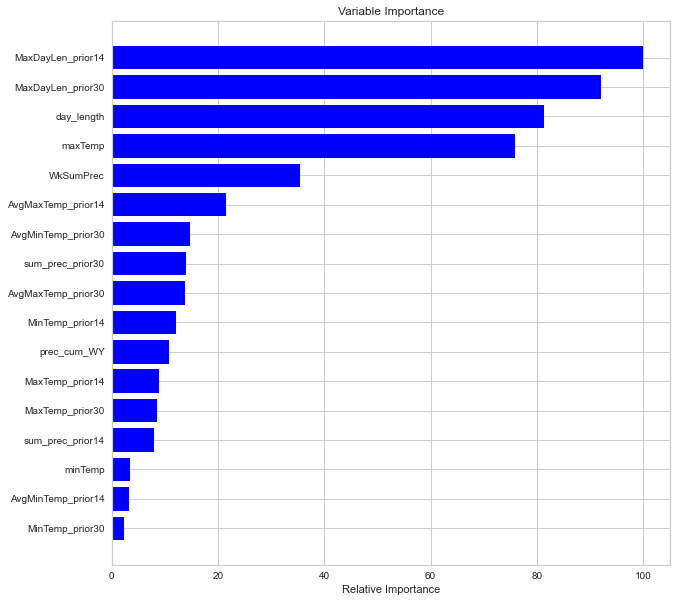

In [64]:
feature_importance = gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center', color = 'blue')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# Summary:

<br> Gradient Boosting performed best on the test data

In [65]:
models_table = pd.DataFrame()
models_table.index = model_list
models_table['accuracy'] = ac_list
models_table['precision'] = precision_list
models_table['recall'] = recall_list

models_table.head(10)

,accuracy,precision,recall
Random Forest,0.963351,2.957576,2.556391
KNN,0.879581,2.786186,1.591415
Extra Trees,0.952880,2.803209,2.562530
Gradient Boosting,0.963351,2.957576,2.575188
